In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

Queremos predecir (?) la longitud de las aletas.

# Data

In [2]:
df = pd.read_csv("datos/penguins.csv").dropna()
df.groupby(["species"])["flipper_length"].describe()

flipper  = df["flipper_length"].values
species = df["species"].values
species = pd.Categorical(df["species"]).codes

min_valor = 8
max_valor = 50
refs = {"Aleta pinguino azul":min_valor,
        "Aleta pingüino emperador":max_valor}

# Modelo 1: no jerárquico


Decidimos armar nuestro primer modelo teniendo en cuenta los valores máximo y mínimo teóricos decidimos modelar la media como una distribución Normal con media en $\frac {emperador + azul}{2}$ y $sigma = 10$.

In [3]:
cat_encode = pd.Categorical(df['species'])
idx = cat_encode.codes
coords = {"species": cat_encode.categories, "species_flat": cat_encode.categories[idx]}

In [4]:
with pm.Model(coords=coords) as model_nj:
    mu = pm.Normal("mu", mu= 29, sigma=10, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")


## Prior Predictive Check

In [6]:
with model_nj:
    trace_nj = pm.sample_prior_predictive(samples=100)

Sampling: [mu, sigma, y]


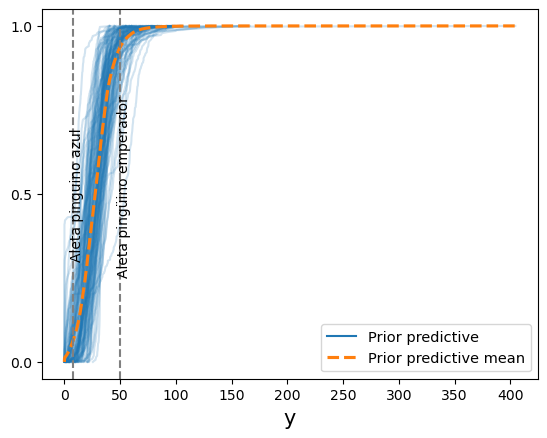

In [7]:
fig, ax = plt.subplots()
az.plot_ppc(trace_nj, group="prior", kind="cumulative", ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90)

Como vemos que tenemos varios valores por fuera de los limites teoricos establecidos, decidimos modificar los priors para que sean menos anchos.

## Redefinicion

In [8]:
with pm.Model(coords=coords) as model_nj:
    mu = pm.Normal("mu", mu=29, sigma=5, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")

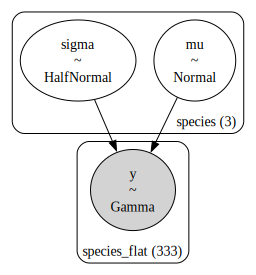

In [9]:
model_nj.to_graphviz()

## Prior Predictive Check

In [10]:
with model_nj:
    trace_nj = pm.sample_prior_predictive(samples=100)

Sampling: [mu, sigma, y]


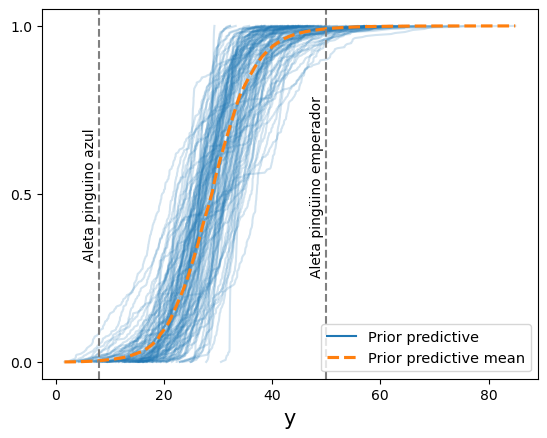

In [11]:
fig, ax = plt.subplots()
az.plot_ppc(trace_nj, group="prior", kind="cumulative", ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90)

## Posterior Predictive Check

In [12]:
with model_nj:
    trace_nj = pm.sample(2000 ,chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_nj.extend(pm.sample_posterior_predictive(trace_nj))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Sampling: [y]


Output()

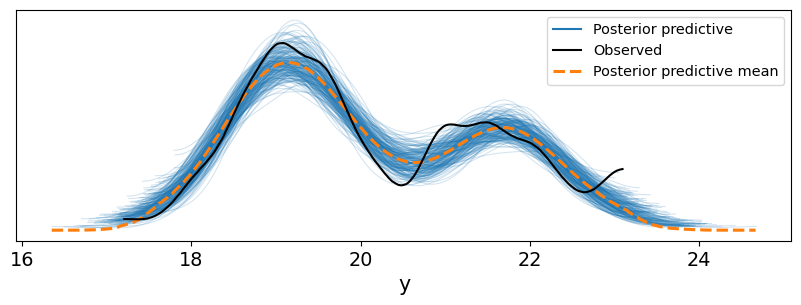

In [13]:
az.plot_ppc(trace_nj, figsize=(10, 3), num_pp_samples=200);

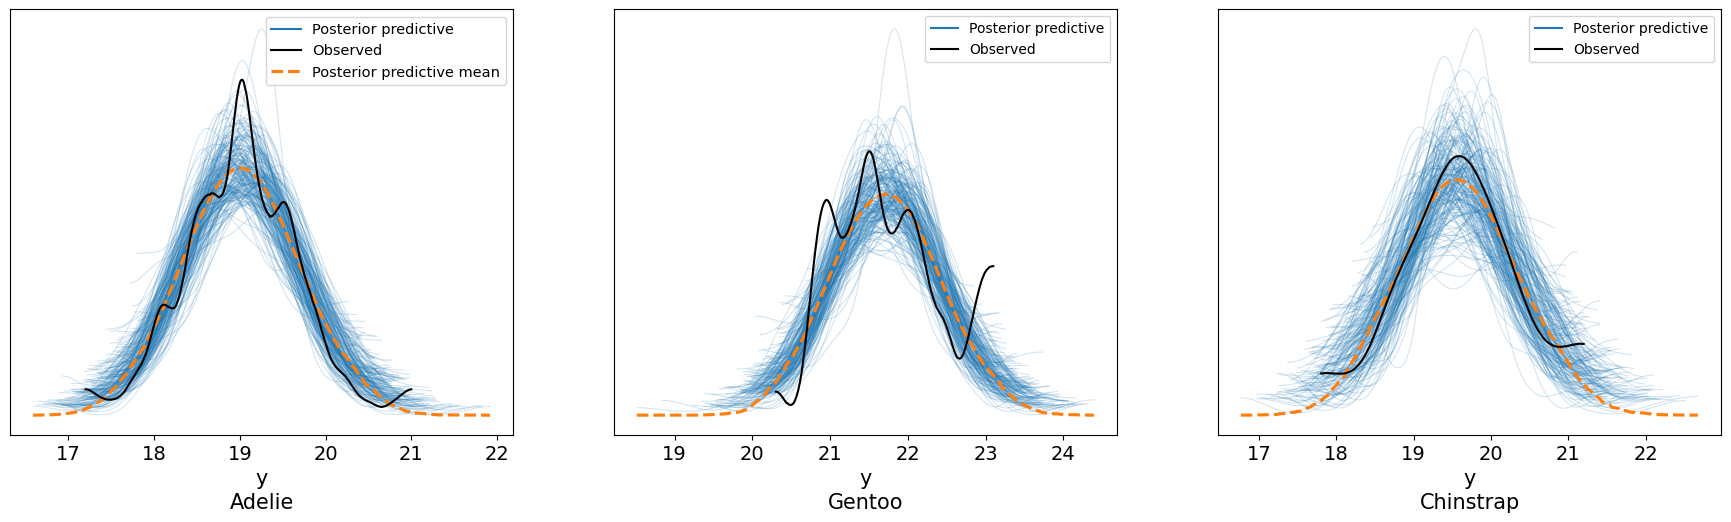

In [14]:
az.plot_ppc(trace_nj, coords={"species_flat": [cat_encode.categories]}, flatten=[], num_pp_samples=200);

Hay algunos patrones que no se capturan bien, seguramente debido a que hay más variables que influyen en el tamaño de las aletas.  
Pero vamos a considerar estos resultados como suficientes, por simplicidad.


## Diagnostico de muestreo

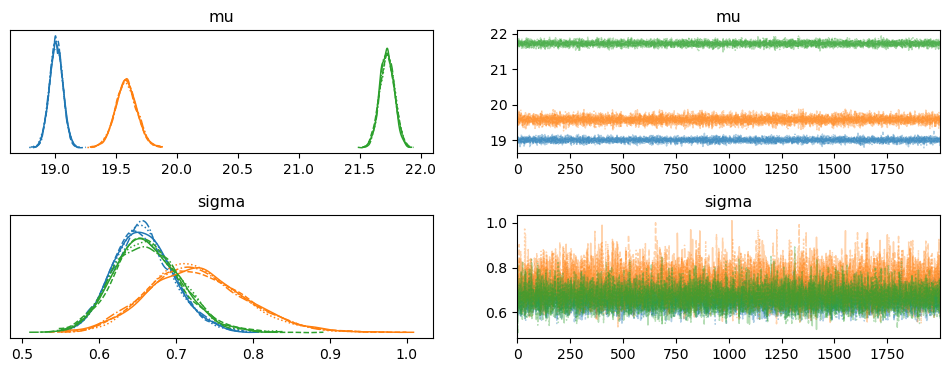

In [15]:
az.plot_trace(trace_nj);
plt.subplots_adjust(hspace=0.5)

In [16]:
az.rhat(trace_nj)

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 1.0 1.0 1.001
    sigma    (species) float64 24B 1.0 1.0 0.9999

In [17]:
az.ess(trace_nj)

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 1.085e+04 1.246e+04 1.354e+04
    sigma    (species) float64 24B 1.139e+04 9.27e+03 1.11e+04

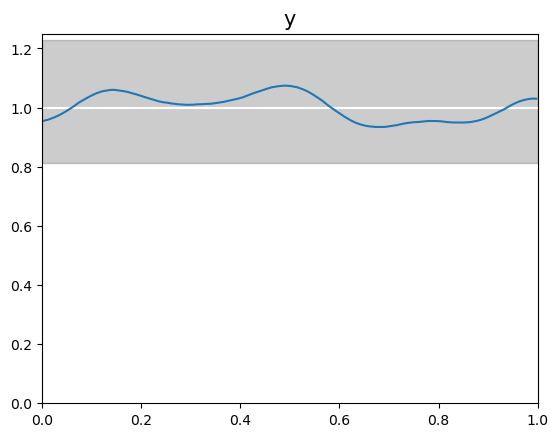

In [18]:
az.plot_bpv(trace_nj);

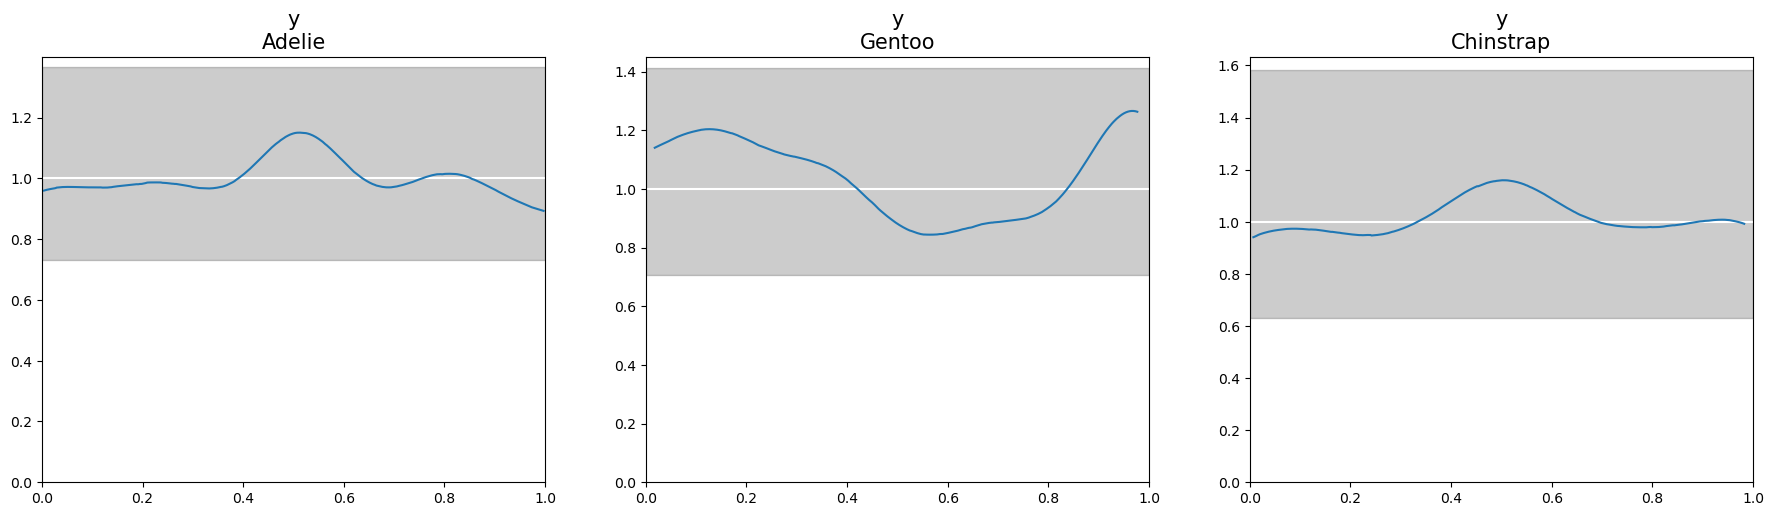

In [19]:
az.plot_bpv(trace_nj,coords={"species_flat": [cat_encode.categories]}, flatten=[]);


# Modelo 2: Jerárquico

Similar al anterior pero con una estructura jerárquica.

In [20]:
with pm.Model(coords=coords) as model_j:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")

    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")


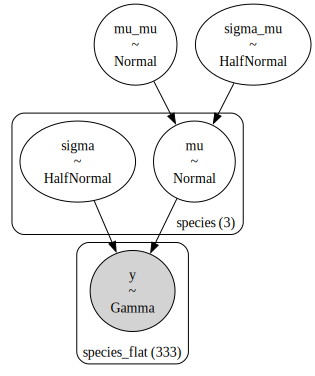

In [21]:
model_j.to_graphviz()

In [22]:
with model_j:
    trace_j = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.


Hubo 55 divergencias en el sampleo. 

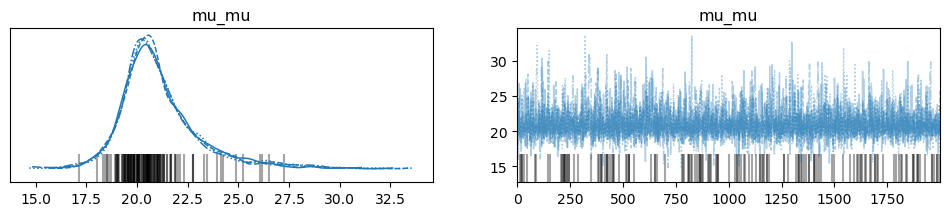

In [23]:
az.plot_trace(trace_j, var_names=["mu_mu"], compact=True);

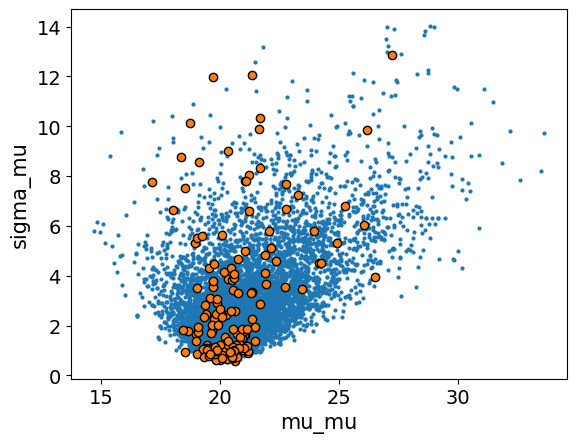

In [24]:
az.plot_pair(trace_j, var_names=['mu_mu', 'sigma_mu'], kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'});

## Redefinición

El muestro es malo, entonces quizas el modelo tambien lo sea. Decidimos cambiar las distribuciones de los priors y aumentar el target_accept a 0.95

In [65]:
with pm.Model(coords=coords) as model_j:
    mu_mu = pm.Gamma("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Gamma("mu", mu=mu_mu, sigma=sigma_mu, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")

with model_j:
    trace_j = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 73 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.


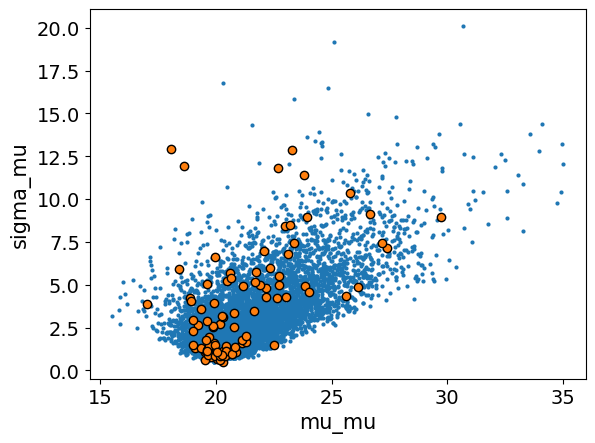

In [66]:
az.plot_pair(trace_j, var_names=['mu_mu', 'sigma_mu'], kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'});

## Redefinicion 2

In [68]:
with pm.Model(coords=coords) as model_j:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")

    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")


In [70]:
with model_j:
    trace_j = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


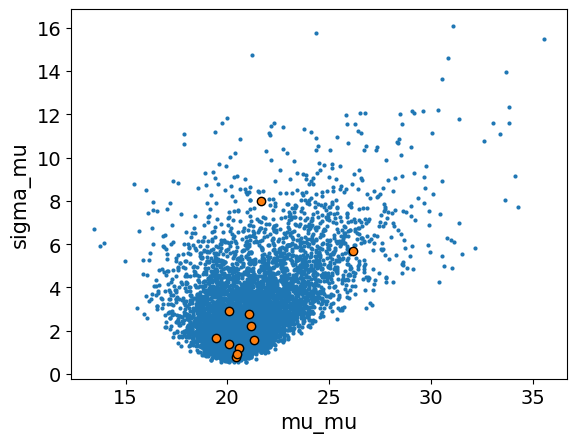

In [71]:
az.plot_pair(trace_j, var_names=['mu_mu', 'sigma_mu'], kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'});

## Prior Predictive Check

In [27]:
with model_j:
    trace_j.extend(pm.sample_prior_predictive(samples = 100))

Sampling: [mu, mu_mu, sigma, sigma_mu, y]


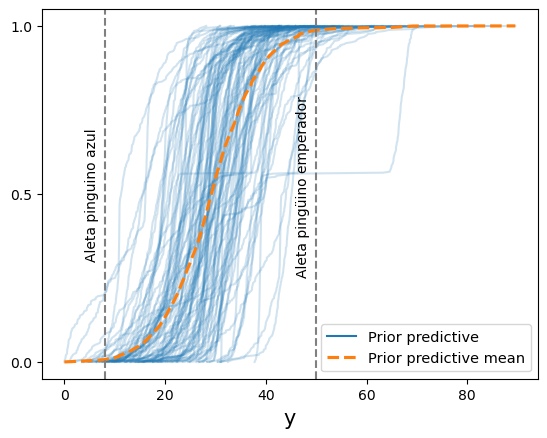

In [28]:
fig, ax = plt.subplots()

az.plot_ppc(trace_j, group="prior", kind="cumulative", ax=ax);

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-4, 0.5-(len(key)/100), key, rotation=90)

## Posterior Predictive Check

Sampling: [y]


Output()

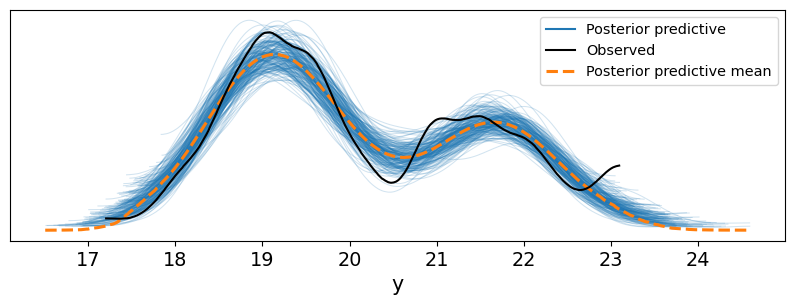

In [67]:
with model_j:
    trace_j.extend(pm.sample_posterior_predictive(trace_j))

az.plot_ppc(trace_j, figsize=(10, 3), num_pp_samples=200);

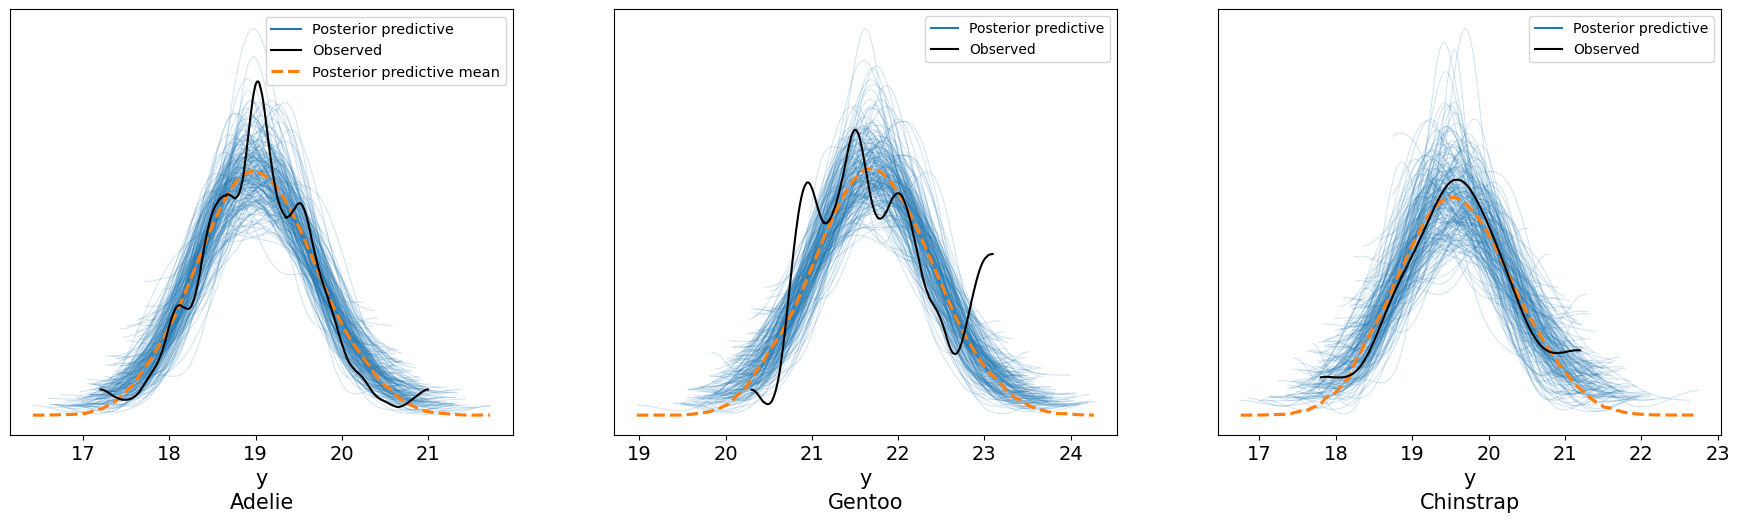

In [30]:
az.plot_ppc(trace_j, coords={"species_flat": [cat_encode.categories]}, flatten=[], num_pp_samples=200);

## Diagnostico de muestreo

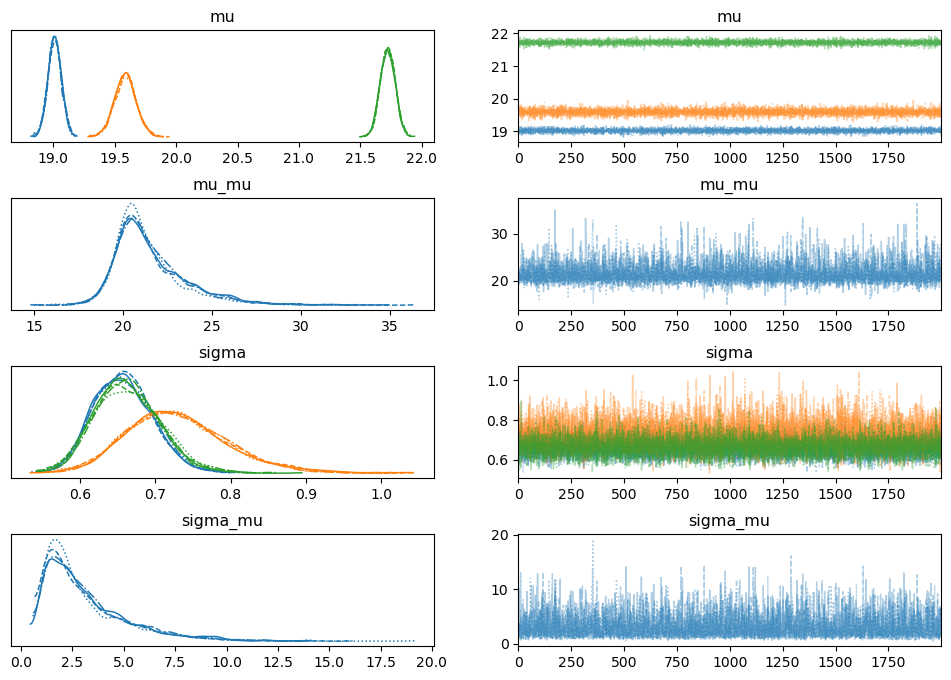

In [31]:
az.plot_trace(trace_j)
plt.subplots_adjust(hspace=0.5);

In [32]:
az.rhat(trace_j, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 1.0 1.0 1.0
    sigma    (species) float64 24B 1.001 0.9998 1.001

In [33]:
az.ess(trace_j)

<xarray.Dataset> Size: 172B
Dimensions:   (species: 3)
Coordinates:
  * species   (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu        (species) float64 24B 8.694e+03 9.31e+03 8.95e+03
    mu_mu     float64 8B 4.581e+03
    sigma     (species) float64 24B 1.05e+04 9.185e+03 9.412e+03
    sigma_mu  float64 8B 4.602e+03

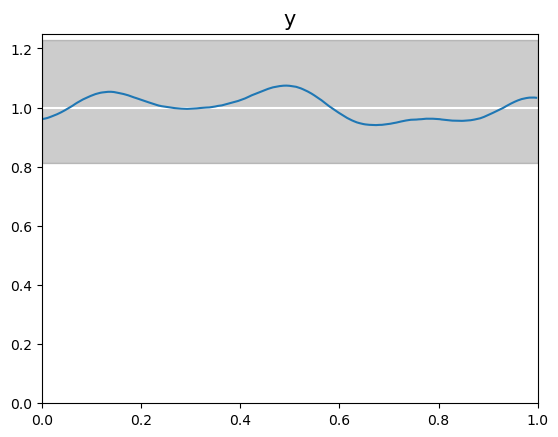

In [34]:
az.plot_bpv(trace_j);

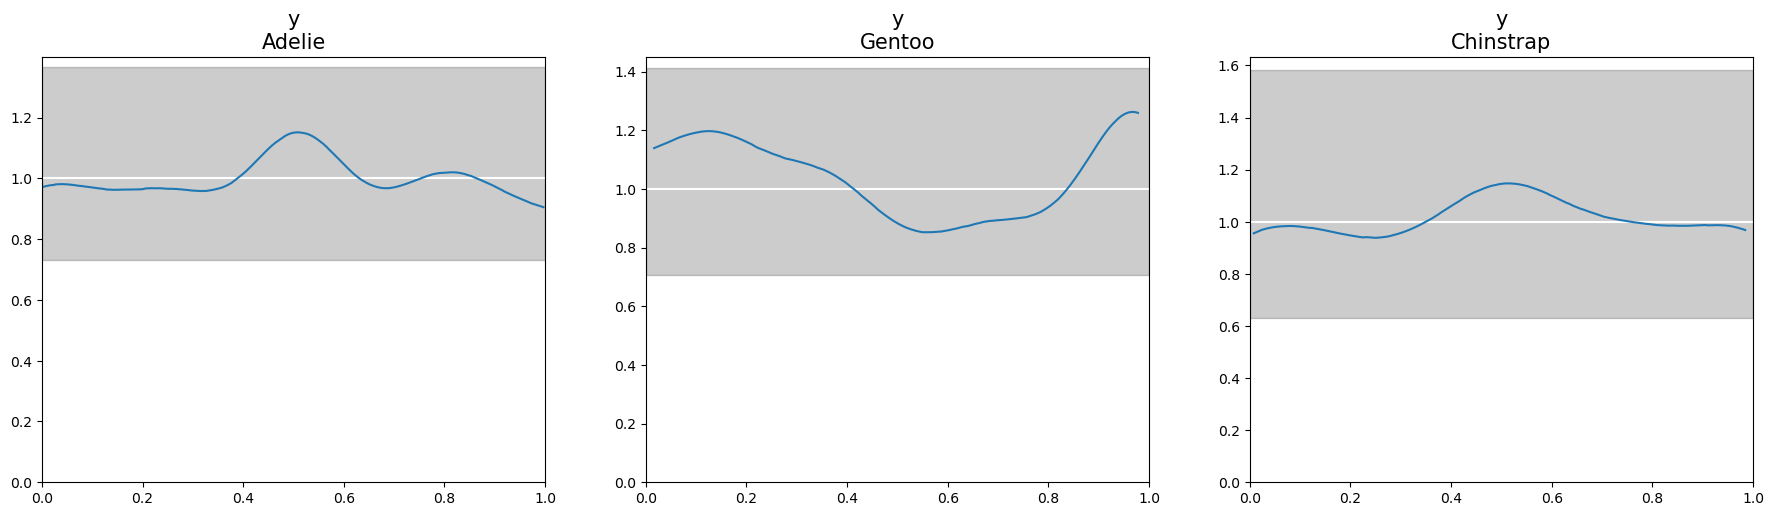

In [35]:
az.plot_bpv(trace_j,coords={"species_flat": [cat_encode.categories]}, flatten=[]);

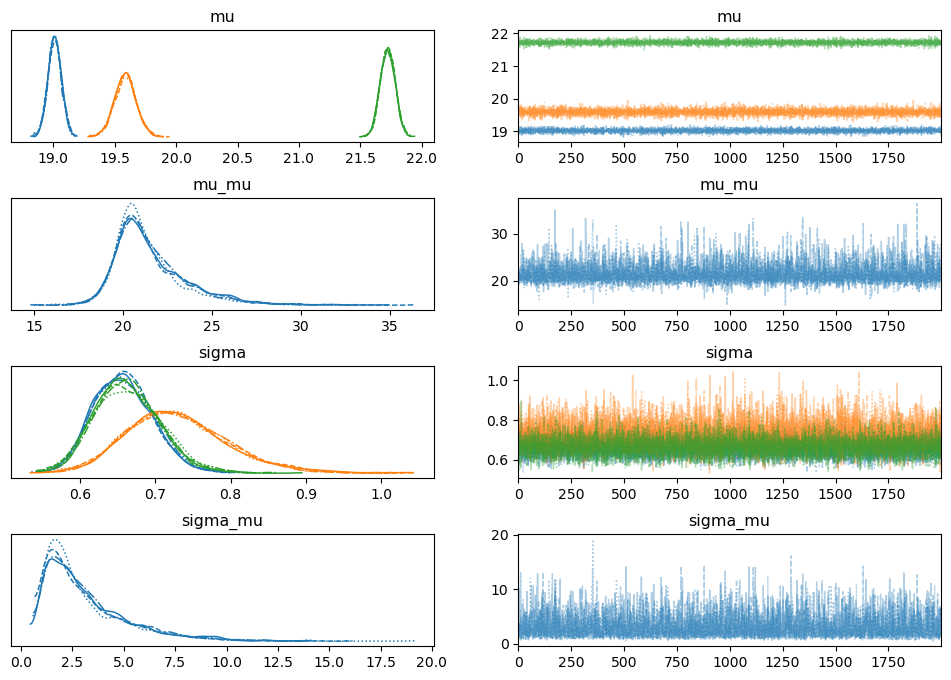

In [36]:
az.plot_trace(trace_j, compact=True)
plt.subplots_adjust(hspace=0.5)

# Modelo 3: grupos especie-isla, no jerarquico

In [37]:
df["species_island"] = df["species"] + " - " + df["island"]

cat_encode = pd.Categorical(df['species_island'])
idx = cat_encode.codes
coords = {"species_island": cat_encode.categories, "species_island_flat": cat_encode.categories[idx]}

In [38]:
with pm.Model(coords=coords) as model_nj_isla:
    mu = pm.Normal("mu", mu=29, sigma=5, dims="species_island")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species_island")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_island_flat")
    

## Prior Predictive Check

In [39]:
with model_nj_isla:
    trace_nj_isla = pm.sample_prior_predictive(samples=100)

Sampling: [mu, sigma, y]


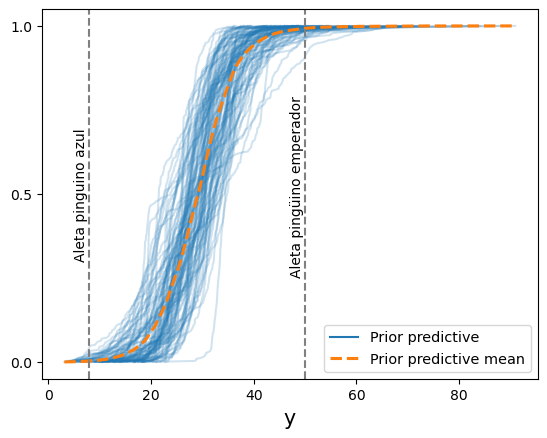

In [40]:
fig, ax = plt.subplots()

az.plot_ppc(trace_nj_isla, group="prior", kind="cumulative", figsize=(10, 3), num_pp_samples=100,ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90);

## Posterior Predictive Check

In [41]:
with model_nj_isla:
    trace_nj_isla = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_nj_isla.extend(pm.sample_posterior_predictive(trace_nj_isla));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
Sampling: [y]


Output()

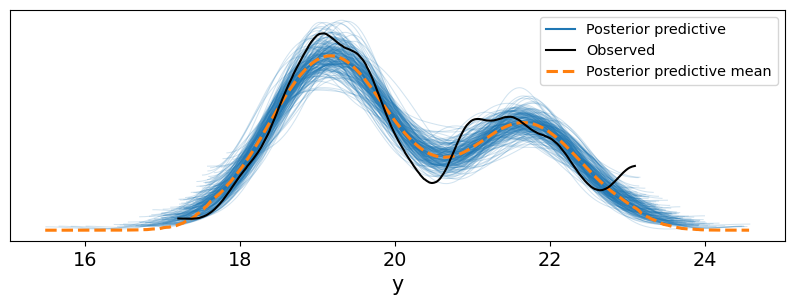

In [42]:
az.plot_ppc(trace_nj_isla, figsize=(10, 3), num_pp_samples=200);

## Diagnostico de muestreo

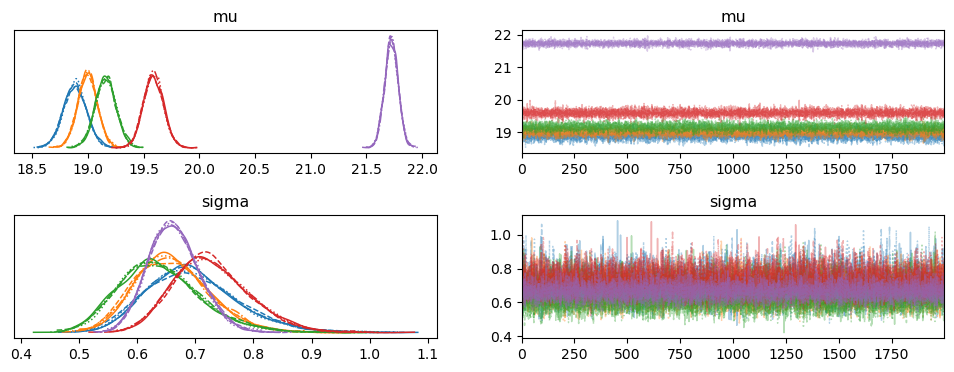

In [43]:
az.plot_trace(trace_nj_isla);
plt.subplots_adjust(hspace=0.5)

In [44]:
az.rhat(trace_nj_isla)


<xarray.Dataset> Size: 440B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 1.002 1.0 1.0 1.0 0.9997
    sigma           (species_island) float64 40B 1.002 1.001 0.9998 1.0 0.9998

In [45]:
az.ess(trace_nj_isla)

<xarray.Dataset> Size: 440B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 9.953e+03 ... 1.07e+04
    sigma           (species_island) float64 40B 1.076e+04 ... 1.135e+04

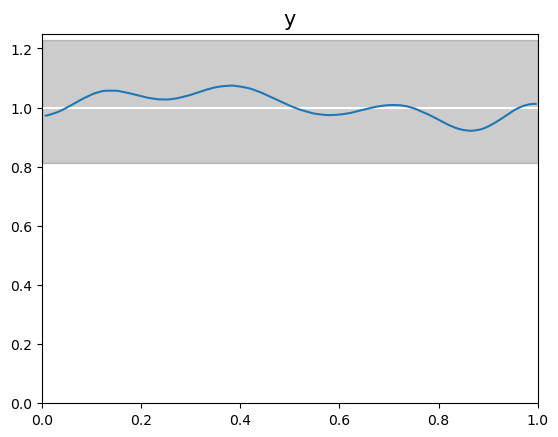

In [46]:
az.plot_bpv(trace_nj_isla);

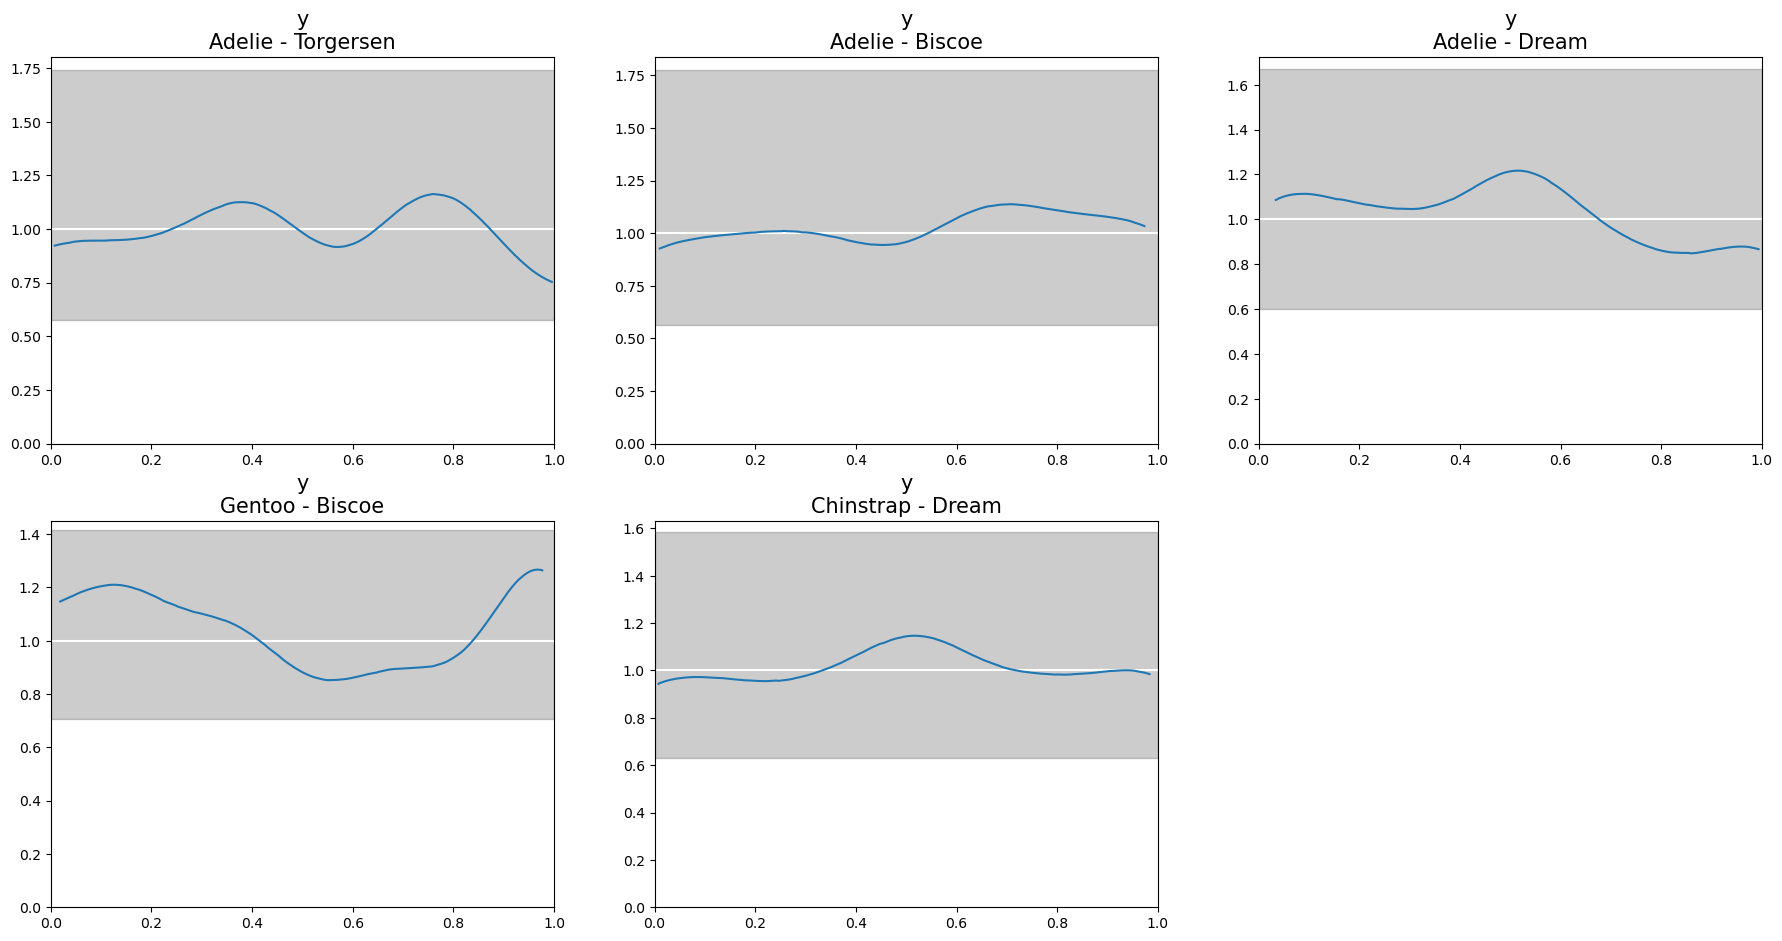

In [47]:
az.plot_bpv(trace_nj_isla,coords={"species_island_flat": [cat_encode.categories]}, flatten=[]);

# Modelo 4: grupos especie-isla jerárquico

In [48]:
with pm.Model(coords=coords) as model_j_isla:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species_island")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species_island")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_island_flat")

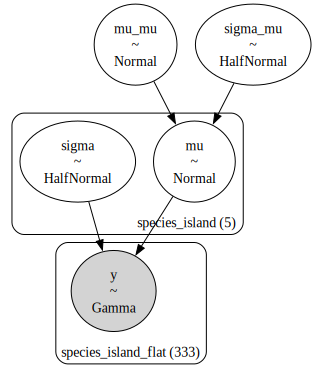

In [49]:
model_j_isla.to_graphviz()

## Prior Predictive Check

In [50]:
with model_j_isla:
    trace_j_isla = pm.sample_prior_predictive(samples=100)

Sampling: [mu, mu_mu, sigma, sigma_mu, y]


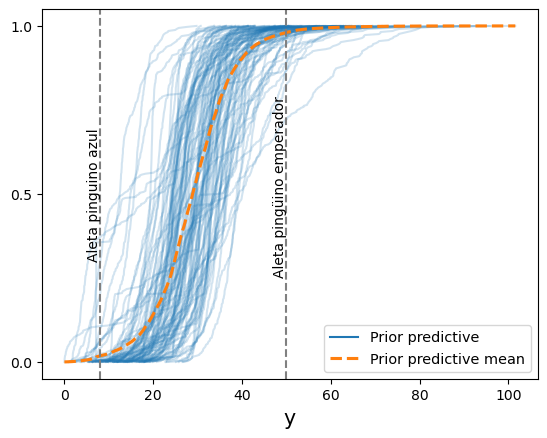

In [51]:
fig, ax = plt.subplots()

az.plot_ppc(trace_j_isla, group="prior", kind="cumulative", figsize=(10, 3), num_pp_samples=100,ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90);

In [52]:
with model_j_isla:
    trace_j_isla = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},progressbar=False, target_accept=0.95)
    trace_j_isla.extend(pm.sample_posterior_predictive(trace_j_isla));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.
Sampling: [y]


Output()

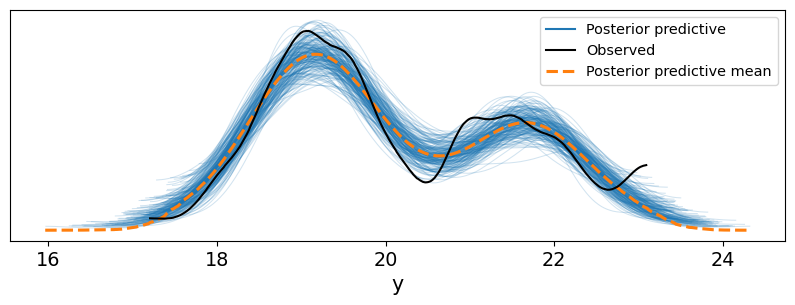

In [53]:
az.plot_ppc(trace_j_isla, figsize=(10, 3), num_pp_samples=200);

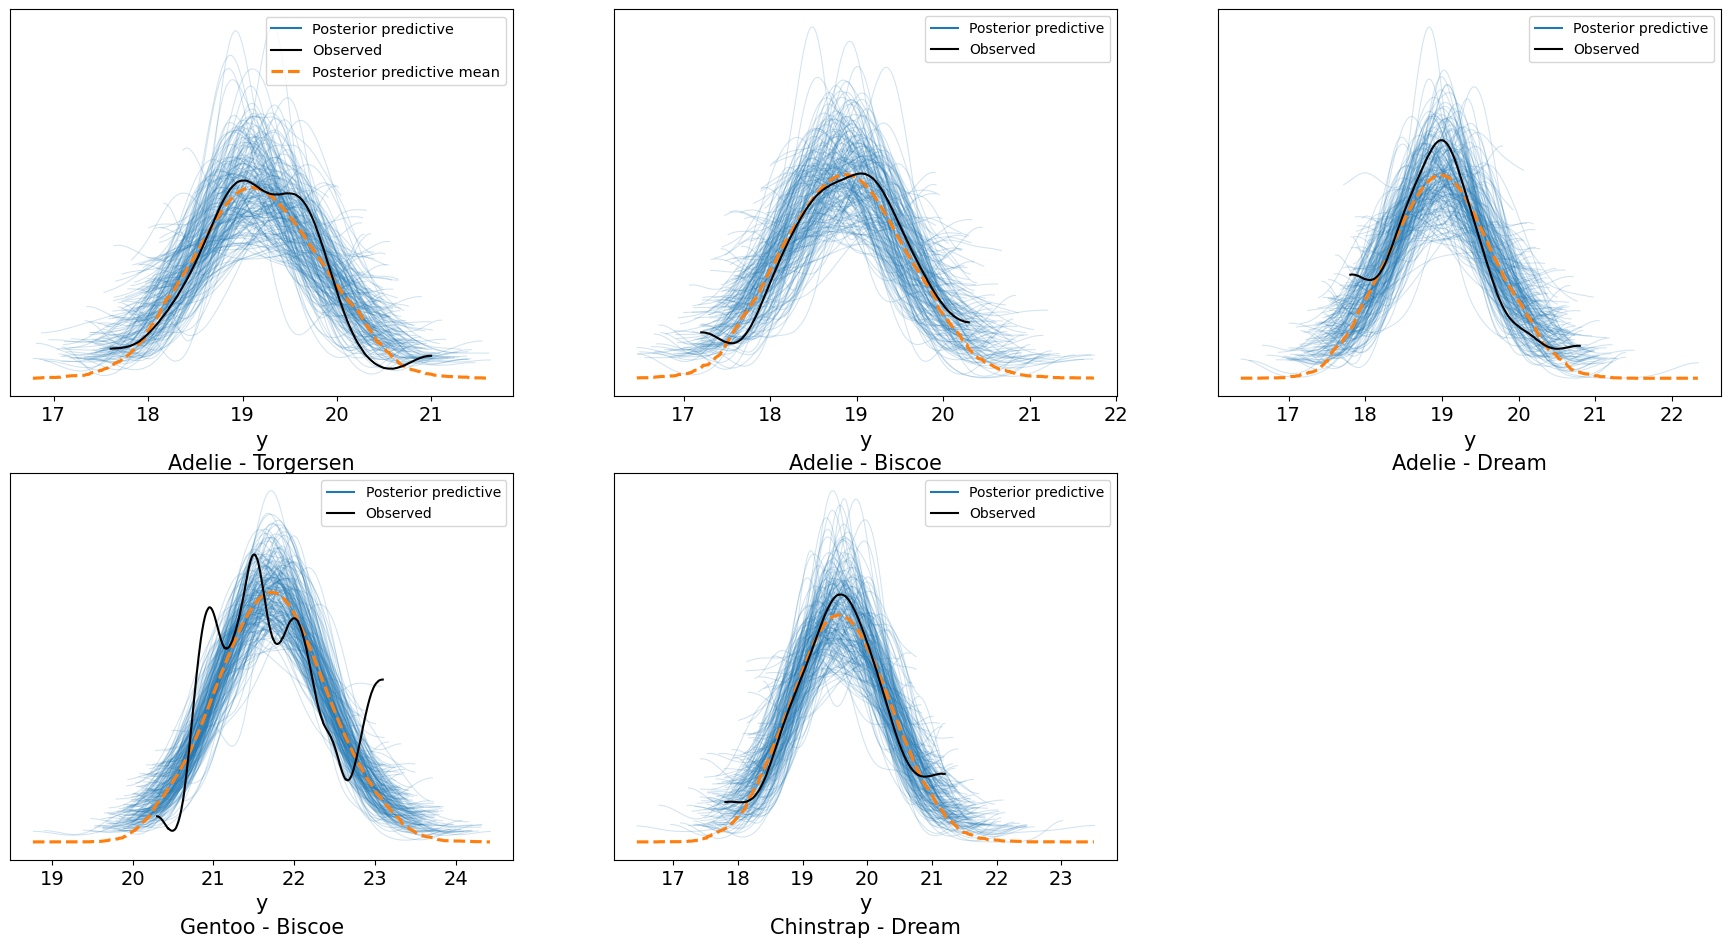

In [54]:
az.plot_ppc(trace_j_isla, coords={"species_island_flat": [cat_encode.categories]}, flatten=[], num_pp_samples=200);

## Diagnosticos de muestreo

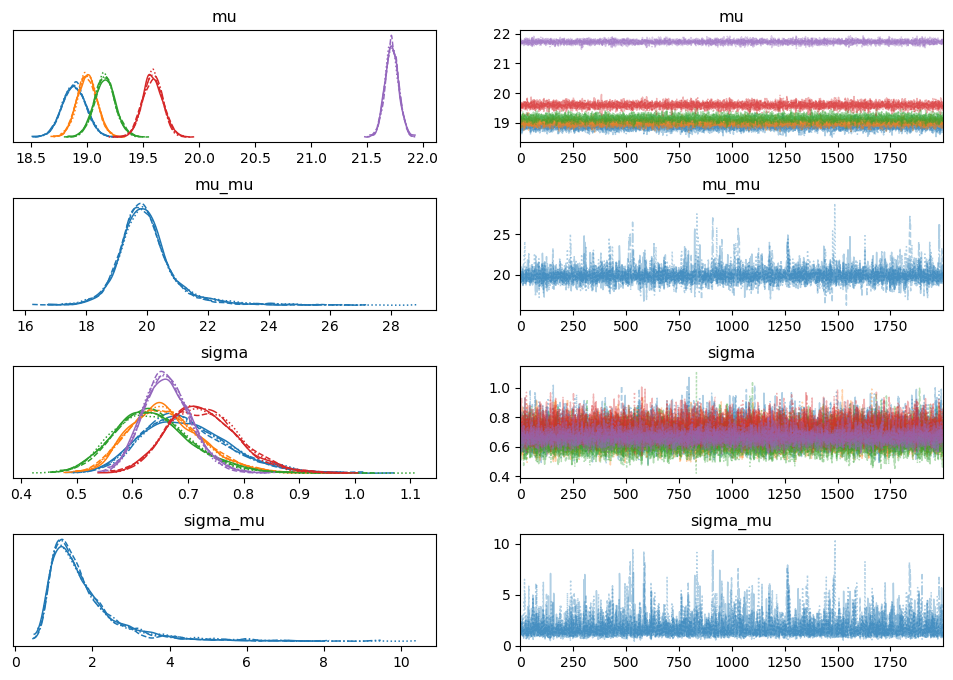

In [55]:
az.plot_trace(trace_j_isla)
plt.subplots_adjust(hspace=0.5);

In [56]:
az.rhat(trace_j_isla)

<xarray.Dataset> Size: 456B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 1.0 1.0 1.001 1.001 1.0
    mu_mu           float64 8B 1.0
    sigma           (species_island) float64 40B 1.0 1.0 1.0 1.001 1.001
    sigma_mu        float64 8B 1.001

In [57]:
az.ess(trace_j_isla)

<xarray.Dataset> Size: 456B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 8.973e+03 ... 8.767e+03
    mu_mu           float64 8B 4.096e+03
    sigma           (species_island) float64 40B 9.963e+03 ... 8.736e+03
    sigma_mu        float64 8B 4.734e+03

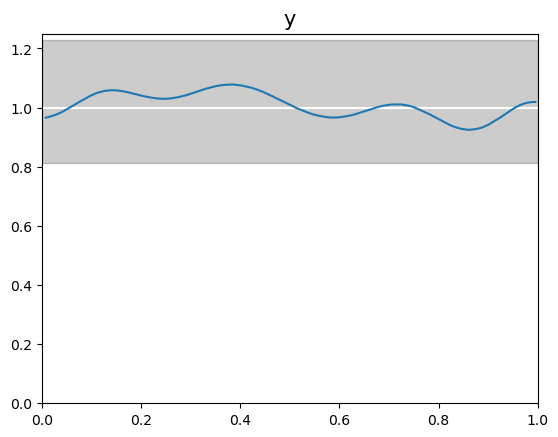

In [58]:
az.plot_bpv(trace_j_isla);

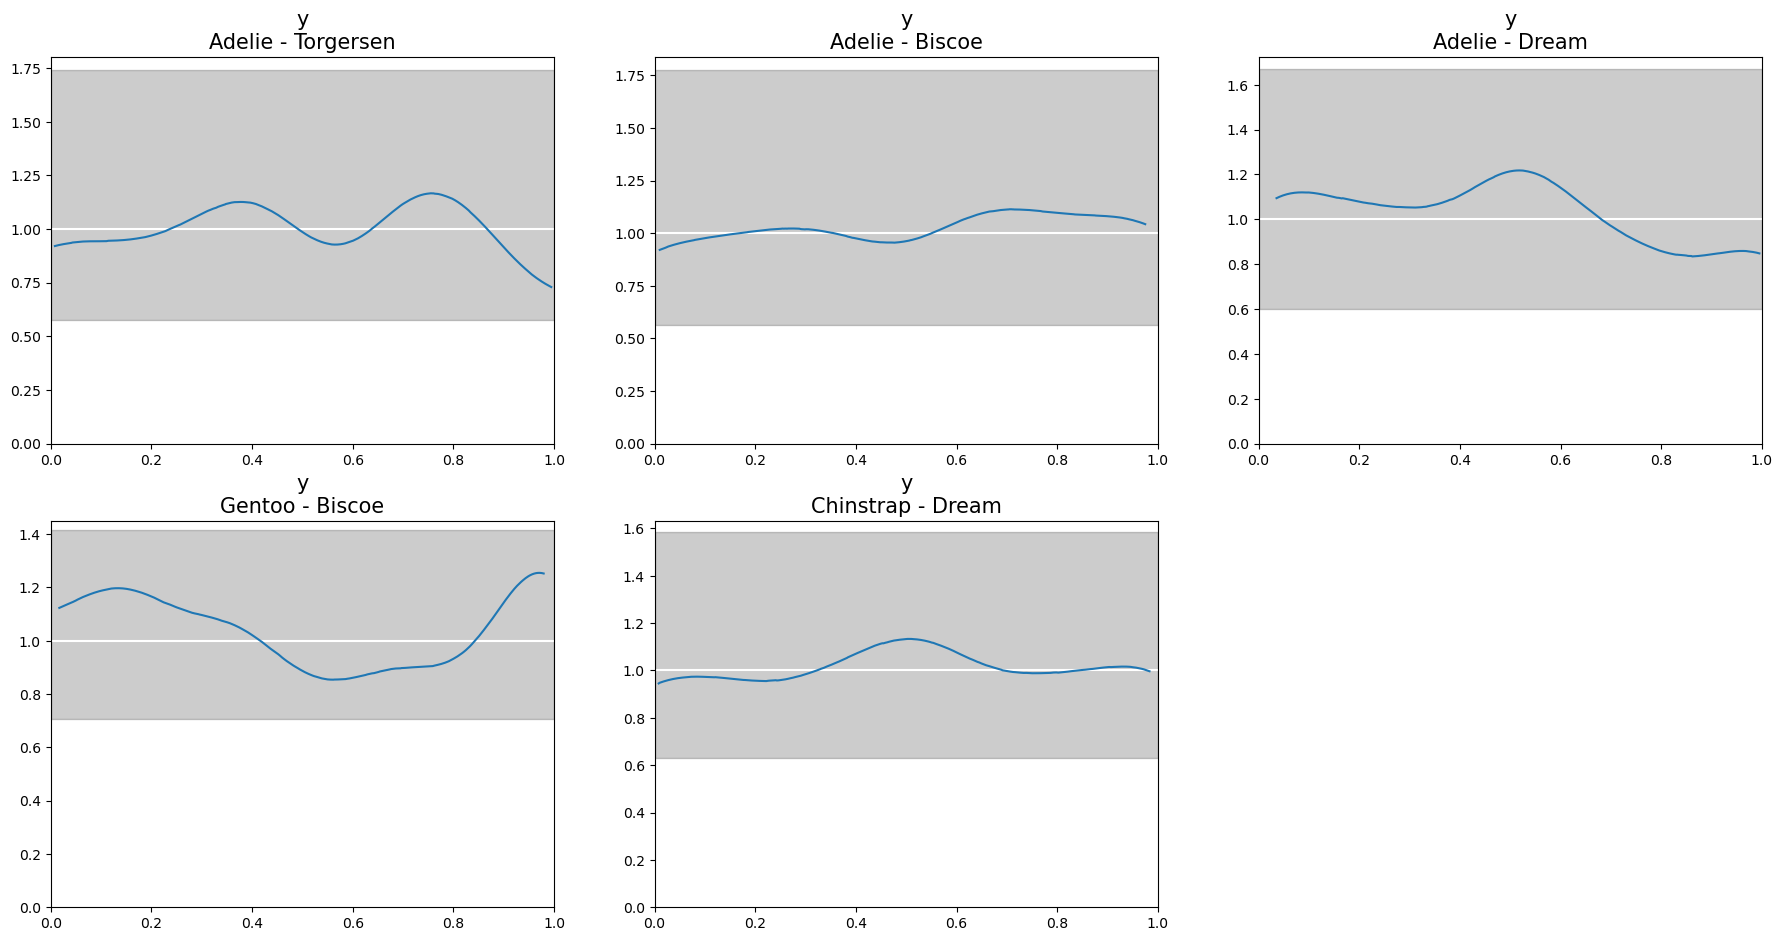

In [59]:
az.plot_bpv(trace_j_isla,coords={"species_island_flat": [cat_encode.categories]}, flatten=[]);  

# Comparacion de modelo

In [60]:
az.compare({"model_nj":trace_nj, "model_j":trace_j, "model_nj_isla":trace_nj_isla, "model_j_isla":trace_j_isla})

rank    elpd_loo     p_loo  elpd_diff        weight         se  \
model_nj          0 -341.425107  5.677426   0.000000  9.602448e-01  12.627236   
model_j           1 -341.497941  5.759200   0.072834  2.616047e-16  12.650380   
model_j_isla      2 -343.552826  9.849310   2.127720  3.975519e-02  12.723049   
model_nj_isla     3 -343.622618  9.890455   2.197511  0.000000e+00  12.710731   

                    dse  warning scale  
model_nj       0.000000    False   log  
model_j        0.071561    False   log  
model_j_isla   2.185526    False   log  
model_nj_isla  2.191370    False   log

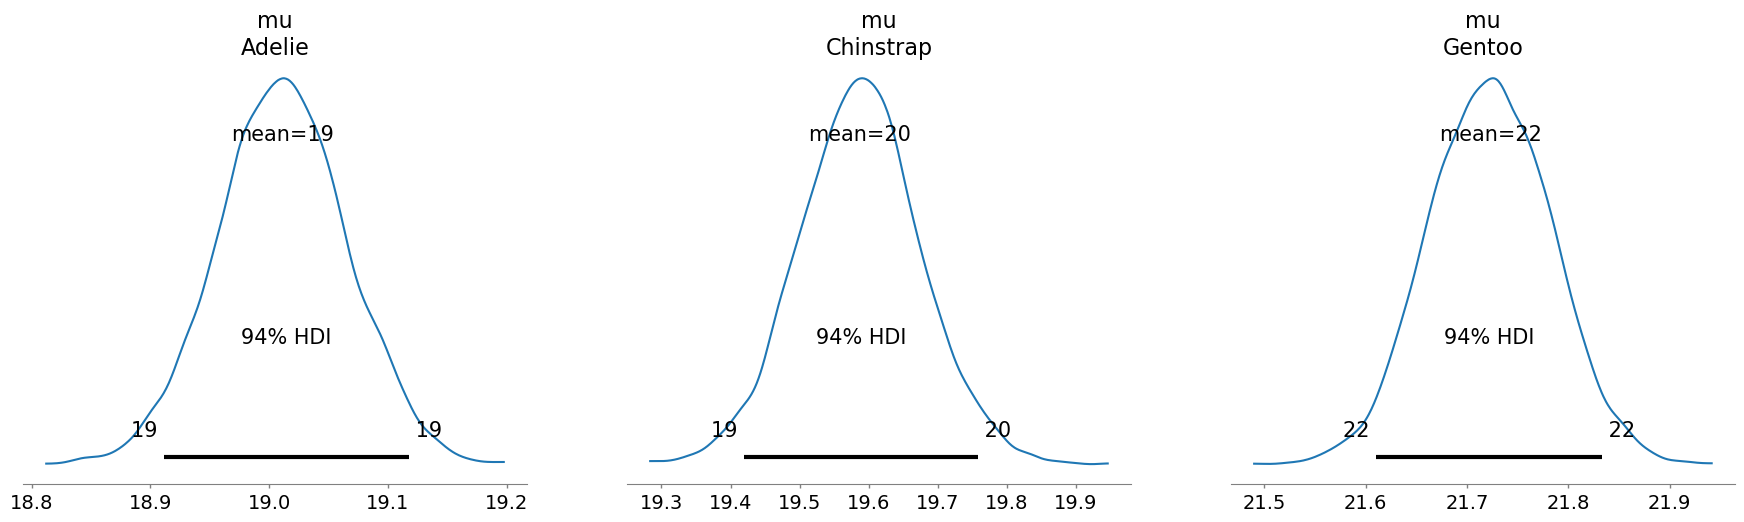

In [61]:
az.plot_posterior(trace_j, var_names=["mu"]);

## d de cohen

In [62]:
cat_encode = pd.Categorical(df['species'])
idx = cat_encode.codes
coords = {"species": cat_encode.categories, "species_flat": cat_encode.categories[idx]}

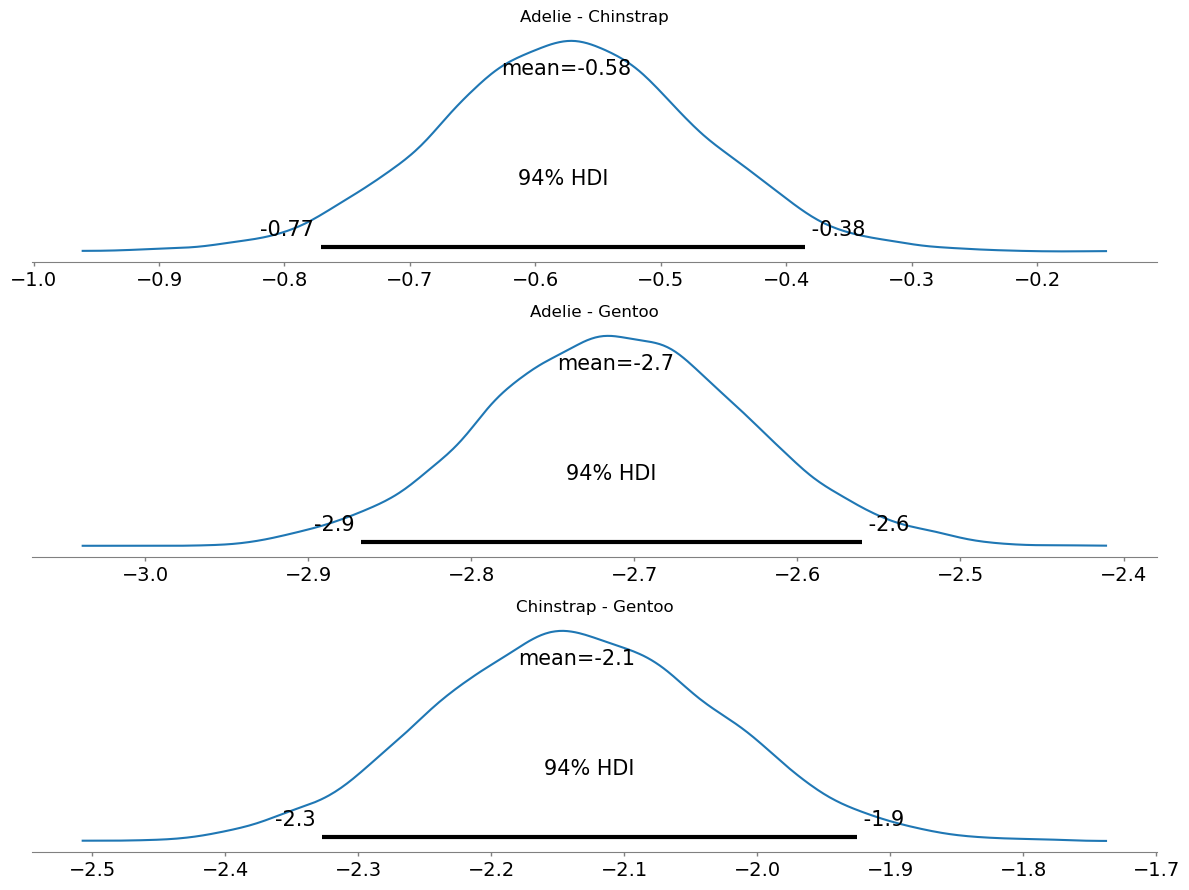

In [63]:
posterior = az.extract(trace_j)

dist = pz.Normal(0, 1)

comparisons = [(cat_encode.categories[i], cat_encode.categories[j]) for i in range(3) for j in range(i+1, 3)]

_, axes = plt.subplots(3,1, figsize=(12, 9), tight_layout=True)

medidas = {}

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = posterior["mu"].sel(species=i) - posterior['mu'].sel(species=j)
    
    d_cohen = (means_diff /
               np.sqrt((posterior["sigma"].sel(species=i)**2 + 
                        posterior["sigma"].sel(species=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))

    medidas[f"{i} - {j}"] = [d_cohen, ps]
    az.plot_posterior(means_diff.values, ax=ax)
    ax.set_title(f"{i} - {j}")
    # ax.plot(0, label=f"d de Cohen = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    # ax.legend()

In [64]:
df_medidas = pd.DataFrame.from_dict(medidas, orient='index', columns=['d_cohen', 'prob_superior'])
df_medidas

d_cohen  prob_superior
Adelie - Chinstrap -0.830918       0.278418
Adelie - Gentoo    -4.112098       0.001821
Chinstrap - Gentoo -3.073316       0.014884